In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)
import itertools
import os

2025-11-17 16:59:39.465106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("GPUs detectadas:", tf.config.list_physical_devices('GPU'))
print("¿Está usando GPU?", tf.test.is_gpu_available())


GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
¿Está usando GPU? True


I0000 00:00:1763416790.948554   12065 gpu_device.cc:2020] Created device /device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9


In [3]:
# configuracion del modelo y data set
DATASET_PATH = 'train'
VALIDATION_DATASET_PATH = 'valid'
IMAGE_SIZE = (224,224)   
BATCH_SIZE = 32
COLOR_MODE = 'rgb'  
EPOCHS = 50
#segun disque pa la grafica pero aja
mixed_precision.set_global_policy('mixed_float16')

In [4]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    label_mode='categorical',
    shuffle=True
)

class_names = train_ds.class_names


Found 1923 files belonging to 3 classes.


I0000 00:00:1763416797.239003   12065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATASET_PATH, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    label_mode='categorical',
    shuffle=False 
)

Found 183 files belonging to 3 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
for images, labels in train_ds.take(1):
    print("imagenes:", images.shape)
    print("etiquetas:", labels.shape)


Shape de imágenes: (32, 224, 224, 3)
Shape de etiquetas: (32, 3)


2025-11-17 17:00:12.771523: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
#pesos pre entrenados
PREPROCESS_FUNCS = {
    "propio": lambda x: x / 255.0,
    "mobilenet_v2": tf.keras.applications.mobilenet_v2.preprocess_input,
    "resnet50": tf.keras.applications.resnet50.preprocess_input,
    
}

def preparar_dataset(ds, preprocess_fn, shuffle=False):
    ds = ds.map(
        lambda x, y: (preprocess_fn(x), y),
        num_parallel_calls=AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

NameError: name 'tf' is not defined

In [9]:
#crear el modelo
def crear_modelo(base_modelo, nombre, num_clases=3):
    base = base_modelo(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base.trainable = False  

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_clases, activation='softmax', dtype='float32')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(f"\n=== Modelo {nombre} ===")
    model.summary()
    return model

In [11]:
train_prop = preparar_dataset(train_ds, PREPROCESS_FUNCS["propio"], shuffle=True)
val_prop = preparar_dataset(val_ds, PREPROCESS_FUNCS["propio"], shuffle=False)

modelP = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  
    layers.Conv2D(32, 3, activation='relu'), # convo
    layers.Conv2D(64, 3, activation='relu'), #convo
    layers.MaxPooling2D(), #poolin
    layers.Conv2D(128, 3, activation='relu'), #convo
    layers.MaxPooling2D(), #pullin
    layers.Flatten(), # aplanado pa dejar el vector creo
    layers.Dense(256, activation='relu'), #funcion activacion
    layers.Dense(3, activation='softmax', dtype='float32') 
])

modelP.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = modelP.fit(
    train_prop,
    validation_data=val_prop,
    epochs=EPOCHS
)

modelP.save("modelo_profundo_propio.keras")

/home/bledny/pruebas/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


2025-11-17 17:01:27.169131: I external/local_xla/xla/service/service.cc:163] XLA service 0x79f574006490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-17 17:01:27.169165: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-11-17 17:01:27.240879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-17 17:01:27.578980: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-11-17 17:01:30.438992: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_426', 8 bytes spill stores, 8 bytes spill loads

2025-11-17 17:01:36.223023: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} f

 2/61 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.2734 - loss: 1.1059    

I0000 00:00:1763416948.582178   12149 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4245 - loss: 1.0876

2025-11-17 17:02:40.270388: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=4} for conv (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[3,110,110,64]{3,2,1,0}, f16[3,108,108,128]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-17 17:02:40.348400: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.964634359s
Trying algorithm eng19{k2=4} for conv (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[3,110,110,64]{3,2,1,0}, f16[3,108,108,128]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0",

61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 291ms/step - accuracy: 0.4540 - loss: 1.0760 - val_accuracy: 0.5082 - val_loss: 1.0455
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4571 - loss: 1.0767 - val_accuracy: 0.5082 - val_loss: 1.0417
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4571 - loss: 1.0716 - val_accuracy: 0.5082 - val_loss: 1.0433
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4571 - loss: 1.0699 - val_accuracy: 0.5082 - val_loss: 1.0456
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4571 - loss: 1.0693 - val_accuracy: 0.5082 - val_loss: 1.0466
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.4571 - loss: 1.0688 - val_accuracy: 0.5082 - val_loss: 1.0467
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4571 - loss: 1.0685 - val_accuracy: 0.5082 - val_loss: 1.0463
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4571 - loss: 1.0682 - val_accuracy: 0.5082 - val_loss:

In [12]:
train_resnet = preparar_dataset(train_ds, PREPROCESS_FUNCS["resnet50"], shuffle=True)
val_resnet = preparar_dataset(val_ds, PREPROCESS_FUNCS["resnet50"], shuffle=False)

model_resnet = crear_modelo(tf.keras.applications.ResNet50, "ResNet50")
history_resnet = model_resnet.fit(
    train_resnet,
    validation_data=val_resnet,
    epochs=EPOCHS
)

model_resnet.save("modelo_resnet50.keras")


=== Modelo ResNet50 ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50


2025-11-17 17:06:55.774836: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


61/61 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.5616 - loss: 1.0410 - val_accuracy: 0.6940 - val_loss: 0.8181
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6630 - loss: 0.7300 - val_accuracy: 0.6995 - val_loss: 0.7811
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6994 - loss: 0.6610 - val_accuracy: 0.7049 - val_loss: 0.7394
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7327 - loss: 0.6097 - val_accuracy: 0.6776 - val_loss: 0.7075
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7535 - loss: 0.5466 - val_accuracy: 0.6940 - val_loss: 0.6908
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7930 - loss: 0.5034 - val_accuracy: 0.6940 - val_loss: 0.6192
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7988 - loss: 0.4821 - val_accuracy: 0.6940 - val_loss: 0.6328
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7956 - loss: 0.4535 - val_accuracy: 0.7049 - val_loss: 

In [14]:
train_mobilenet = preparar_dataset(train_ds, PREPROCESS_FUNCS["mobilenet_v2"], shuffle=True)
val_mobilenet = preparar_dataset(val_ds, PREPROCESS_FUNCS["mobilenet_v2"], shuffle=False)

model_mobilenet = crear_modelo(tf.keras.applications.MobileNetV2, "MobileNetV2")
history_mobilenet = model_mobilenet.fit(
    train_mobilenet,
    validation_data=val_mobilenet,
    epochs=EPOCHS
)

model_mobilenet.save("modelo_mobilenetv2.keras")


=== Modelo MobileNetV2 ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50


2025-11-17 17:15:17.045935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19268096 bytes after encountering the first element of size 19268096 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-11-17 17:15:17.926803: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 17:15:24.765887: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-17 17:15:28.662204: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorit

61/61 ━━━━━━━━━━━━━━━━━━━━ 59s 489ms/step - accuracy: 0.5949 - loss: 0.8876 - val_accuracy: 0.6175 - val_loss: 0.7335
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6916 - loss: 0.6762 - val_accuracy: 0.6831 - val_loss: 0.6710
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7265 - loss: 0.6043 - val_accuracy: 0.6667 - val_loss: 0.6172
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7676 - loss: 0.5204 - val_accuracy: 0.7377 - val_loss: 0.5849
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7904 - loss: 0.4816 - val_accuracy: 0.7486 - val_loss: 0.5743
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8118 - loss: 0.4395 - val_accuracy: 0.7541 - val_loss: 0.5354
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8284 - loss: 0.4129 - val_accuracy: 0.8142 - val_loss: 0.5051
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8518 - loss: 0.3722 - val_accuracy: 0.8033 - val_loss: 

In [13]:
model_mobilenet.save_weights("mobilenetv2.weights.h5")

In [21]:
print("\n=== Evaluación final ===")
loss_m, acc_m = model_mobilenet.evaluate(val_mobilenet)
print(f"MobileNetV2 val_accuracy: {acc_m:.3f}")

loss_r, acc_r = model_resnet.evaluate(val_resnet)
print(f"ResNet50 val_accuracy: {acc_r:.3f}")

loss_p, acc_p = modelP.evaluate(val_prop)
print(f"Modelo propio val_accuracy: {acc_p:.3f}")


=== Evaluación final ===
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8142 - loss: 0.6776
MobileNetV2 → val_accuracy: 0.814
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7814 - loss: 0.9374
ResNet50 → val_accuracy: 0.781
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5082 - loss: 1.0428
Modelo propio → val_accuracy: 0.508


In [16]:
def evaluar_modelo(model, history, val_ds, model_name, class_names,
                   results_dict, output_dir="resultados"):
    """
    model: modelo Keras ya entrenado
    history: objeto History devuelto por model.fit(...)
    val_ds: dataset de validación (imagenes, etiquetas one-hot)
    model_name: nombre identificador (ej: "CNN_Propia", "ResNet50", "MobileNetV2")
    class_names: lista de nombres de clases
    results_dict: diccionario donde se guardan todas las métricas
    """

    #curvas
    plot_learning_curves(history, model_name, output_dir=output_dir)

    
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)

   
    y_true_list = []
    y_pred_list = []

    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true_list.append(labels.numpy())
        y_pred_list.append(preds)

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_classes,
        y_pred_classes,
        labels=range(len(class_names))
    )

    precision_macro = precision.mean()
    recall_macro = recall.mean()
    f1_macro = f1.mean()

    
    cm = confusion_matrix(y_true_classes, y_pred_classes, labels=range(len(class_names)))
    plot_confusion_matrix(cm, class_names, model_name, output_dir=output_dir)

    
    print(f"\n===== {model_name} =====")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val accuracy: {val_acc:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    
    results_dict[model_name] = {
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "precision_por_clase": dict(zip(class_names, precision)),
        "recall_por_clase": dict(zip(class_names, recall)),
        "f1_por_clase": dict(zip(class_names, f1)),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "support": dict(zip(class_names, support)),
    }


In [17]:
def plot_model_comparison(results, output_dir="resultados"):
    os.makedirs(output_dir, exist_ok=True)

    model_names = list(results.keys())
    accs = [results[m]["val_accuracy"] for m in model_names]
    f1s = [results[m]["f1_macro"] for m in model_names]

    # Accuracy
    plt.figure()
    plt.bar(model_names, accs)
    plt.title("Comparación de accuracy en validación")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.savefig(os.path.join(output_dir, "comparacion_accuracy.png"), dpi=300)
    plt.close()

    # F1 macro
    plt.figure()
    plt.bar(model_names, f1s)
    plt.title("Comparación de F1 macro")
    plt.ylabel("F1 macro")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.savefig(os.path.join(output_dir, "comparacion_f1_macro.png"), dpi=300)
    plt.close()


In [18]:
def plot_learning_curves(history, model_name, output_dir="resultados"):
    os.makedirs(output_dir, exist_ok=True)

    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{model_name}_accuracy.png"), dpi=300)
    plt.close()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val loss')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{model_name}_loss.png"), dpi=300)
    plt.close()


def plot_confusion_matrix(cm, class_names, model_name, output_dir="resultados"):
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.savefig(os.path.join(output_dir, f"{model_name}_confusion_matrix.png"), dpi=300)
    plt.close()


In [22]:
results = {}

evaluar_modelo(modelP,          history2,        val_prop, "CNN_Propia",   class_names, results)
evaluar_modelo(model_resnet,    history_resnet,  val_resnet, "ResNet50",     class_names, results)
evaluar_modelo(model_mobilenet, history_mobilenet, val_mobilenet, "MobileNetV2", class_names, results)

plot_model_comparison(results)

/home/bledny/pruebas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bledny/pruebas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bledny/pruebas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/b


===== CNN_Propia =====
Val loss: 1.0428
Val accuracy: 0.5082

Reporte de clasificación:
              precision    recall  f1-score   support

       Alert       0.51      1.00      0.67        93
  MicroSleep       0.00      0.00      0.00        41
        Yawn       0.00      0.00      0.00        49

    accuracy                           0.51       183
   macro avg       0.17      0.33      0.22       183
weighted avg       0.26      0.51      0.34       183


===== ResNet50 =====
Val loss: 0.9374
Val accuracy: 0.7814

Reporte de clasificación:
              precision    recall  f1-score   support

       Alert       0.83      0.74      0.78        93
  MicroSleep       0.61      0.76      0.67        41
        Yawn       0.88      0.88      0.88        49

    accuracy                           0.78       183
   macro avg       0.77      0.79      0.78       183
weighted avg       0.79      0.78      0.78       183


===== MobileNetV2 =====
Val loss: 0.6776
Val accuracy: 0.8142

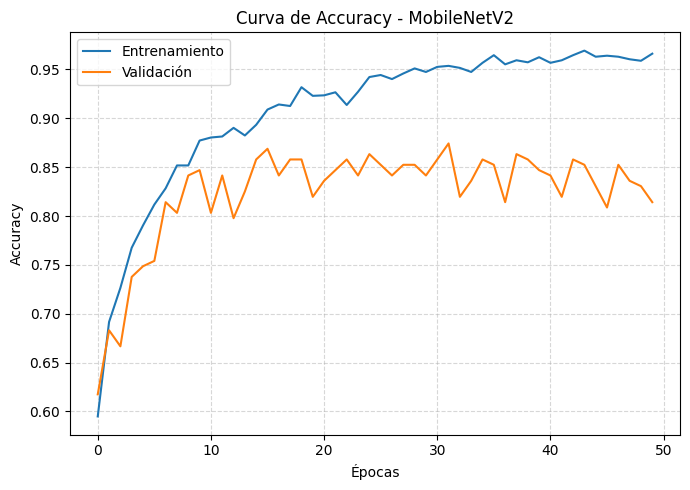

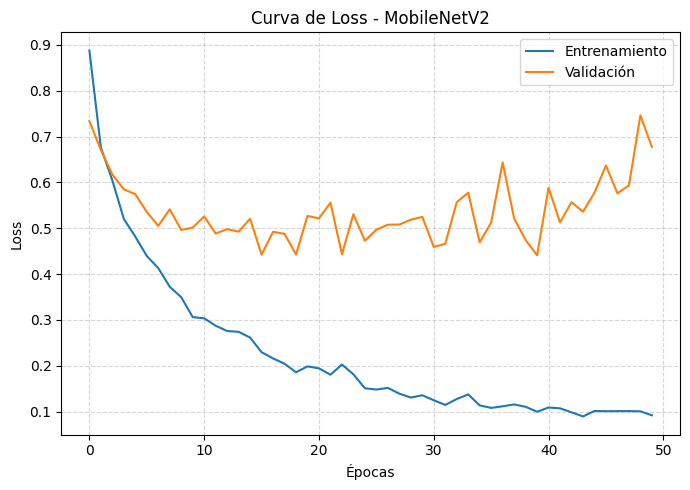

In [23]:
def plot_learning_curves(history, model_name):
    # Accuracy
    plt.figure(figsize=(7,5))
    plt.plot(history.history["accuracy"], label="Entrenamiento")
    plt.plot(history.history["val_accuracy"], label="Validación")
    plt.title(f"Curva de Accuracy - {model_name}")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_name}_curva_accuracy.png", dpi=300)
    plt.show()

    # Loss
    plt.figure(figsize=(7,5))
    plt.plot(history.history["loss"], label="Entrenamiento")
    plt.plot(history.history["val_loss"], label="Validación")
    plt.title(f"Curva de Loss - {model_name}")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_name}_curva_loss.png", dpi=300)
    plt.show()


plot_learning_curves(history_mobilenet, "MobileNetV2")
